# MAST30034_Applied Data Science_Project1

## Import Libraries

In [1]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from geodatasets import get_path
import pandas as pd
import geopandas as gpd
from pyspark.sql.functions import date_format, hour, dayofweek
import seaborn as sns
from scipy.stats import chi2_contingency
from pyspark.sql.functions import count as spark_count
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

In [2]:
# Create a spark session
spark = (
SparkSession.builder.appName("ADS project 1")
.config("spark.sql.repl.eagerEval.enabled", True)
.config("spark.driver.memory","6G")
.config("spark.executor.memory","6G")
.config("spark.sql.parquet.cacheMetadata", "true")
.config("spark.sql.session.timeZone", "Etc/UTC")
.getOrCreate()
)

24/08/22 13:37:34 WARN Utils: Your hostname, chumuhandeMacBook-Air-2.local resolves to a loopback address: 127.0.0.1; using 10.13.132.182 instead (on interface en0)
24/08/22 13:37:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/22 13:37:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/08/22 13:37:37 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Read Data

In [3]:
taxi_data = spark.read.parquet('../data/data_after_preprocessing/taxi')
citybike_data = spark.read.parquet('../data/data_after_preprocessing/citybike')
weather_data = spark.read.parquet('../data/data_after_preprocessing/weather')

In [4]:
taxi_zones = gpd.read_file("../data/raw/NYCTLC_data/taxi_zone_shipfile/taxi_zones.shp")

In [5]:
taxi_data.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'duration']

In [6]:
citybike_data.columns

['ride_id',
 'rideable_type',
 'started_at',
 'ended_at',
 'start_station_name',
 'start_station_id',
 'end_station_name',
 'end_station_id',
 'start_lat',
 'start_lng',
 'end_lat',
 'end_lng',
 'member_casual',
 'duration']

In [7]:
weather_data.columns

['name',
 'datetime',
 'temp',
 'feelslike',
 'dew',
 'humidity',
 'precip',
 'precipprob',
 'preciptype',
 'snow',
 'snowdepth',
 'windgust',
 'windspeed',
 'winddir',
 'sealevelpressure',
 'cloudcover',
 'visibility',
 'solarradiation',
 'solarenergy',
 'uvindex',
 'severerisk',
 'conditions',
 'icon',
 'stations']

## Research on taxi demand of the map

Draw the map for New York

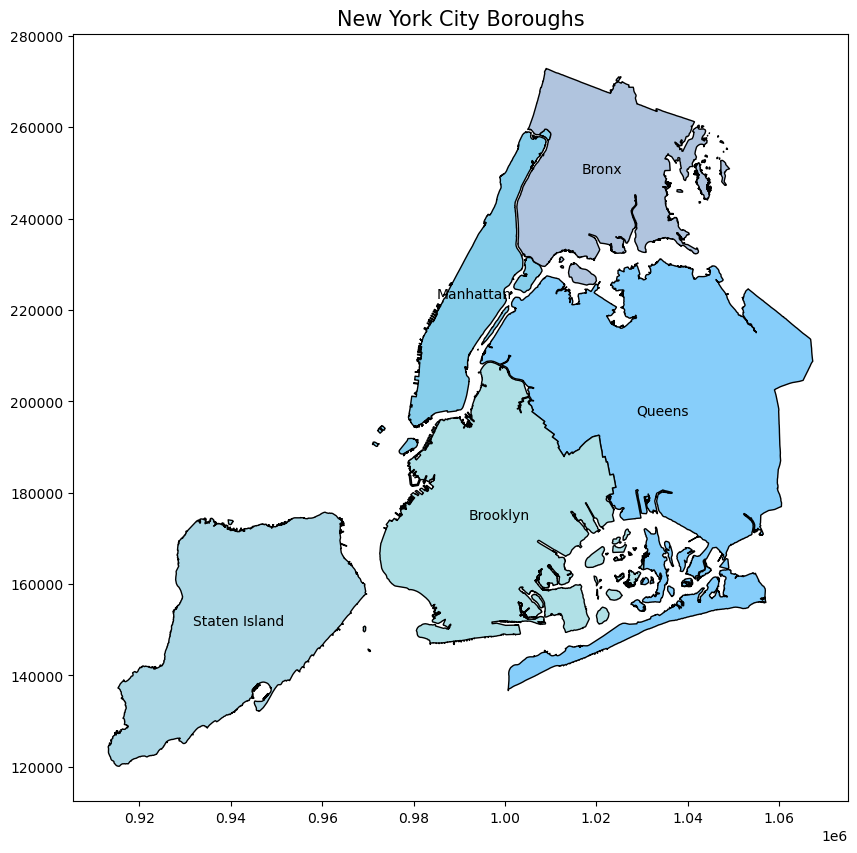

In [8]:
path_to_file = get_path('nybb')
nyc_map = gpd.read_file(path_to_file)
colors = ['#add8e6', '#87cefa', '#b0e0e6', '#87ceeb', '#b0c4de']
fig, ax = plt.subplots(figsize=(10, 10))
nyc_map.plot(ax=ax, color=colors, edgecolor='black')
nyc_map.apply(lambda x: ax.annotate(text=x['BoroName'], xy=x.geometry.centroid.coords[0], ha='center', color='black'), axis=1)
plt.title("New York City Boroughs", fontsize=15)
plt.show()

Draw the taxizone shipfile for New York

<Axes: >

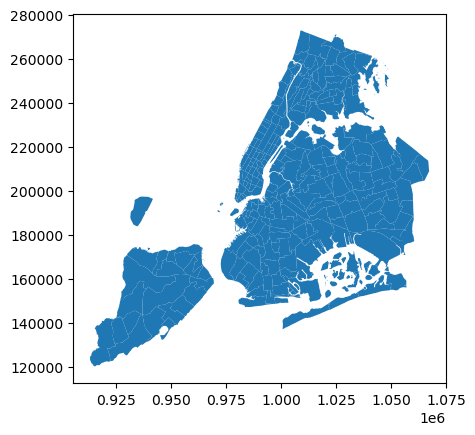

In [9]:
taxi_zones.plot()

Taxi boarding counted by zone

<Figure size 1200x800 with 0 Axes>

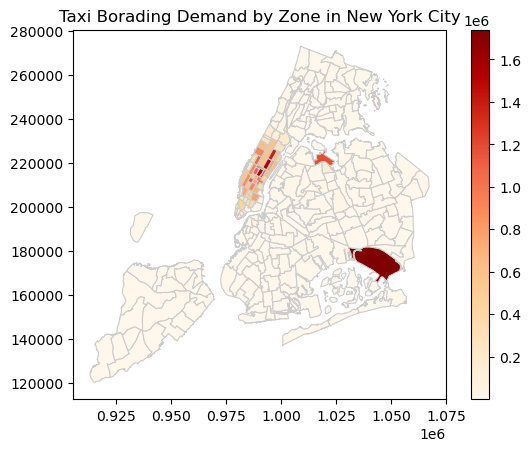

In [10]:
# Count the number of passengers in each zone of NewYork
demand_data_PUL = taxi_data.groupBy("PULocationID").count()
demand_data_PUL = demand_data_PUL.withColumnRenamed("count", "demand")
pandas_demand_data_PUL = demand_data_PUL.toPandas()

# Combine the zone data with the taxi demand data
taxi_zones_merge_PUL = taxi_zones.merge(pandas_demand_data_PUL, how='left', left_on='LocationID', right_on='PULocationID')

# Drawing an image
plt.figure(figsize=(12, 8))
taxi_zones_merge_PUL.plot(column='demand', cmap='OrRd', linewidth=0.8, edgecolor='0.8', legend=True)
plt.title('Taxi Borading Demand by Zone in New York City')
plt.show()

In [11]:
# Write the top 10 zone
top_10_zones_PUL = taxi_zones_merge_PUL.nlargest(10, 'demand')[['zone', 'demand']]
top_10_zones_PUL

,zone,demand
131,JFK Airport,1739961.0
236,Upper East Side South,1561016.0
160,Midtown Center,1546733.0
235,Upper East Side North,1374460.0
161,Midtown East,1190014.0
137,LaGuardia Airport,1176993.0
185,Penn Station/Madison Sq West,1140755.0
229,Times Sq/Theatre District,1103716.0
141,Lincoln Square East,1086038.0
169,Murray Hill,982015.0


Taxi drop-off zone count

<Figure size 1200x800 with 0 Axes>

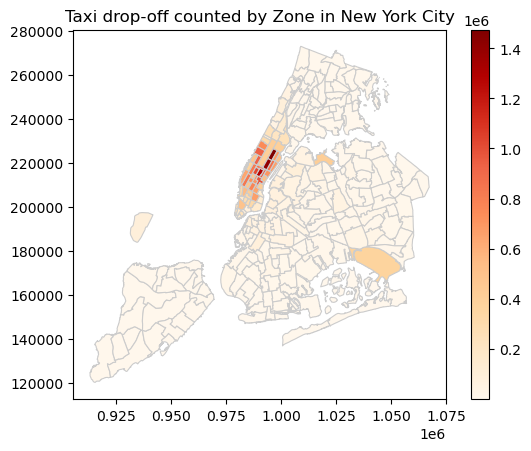

In [12]:
# Count the number of passengers in each zone of NewYork
demand_data_DOL = taxi_data.groupBy("DOLocationID").count()
demand_data_DOL = demand_data_DOL.withColumnRenamed("count", "demand")
pandas_demand_data_DOL = demand_data_DOL.toPandas()

# Combine the zone data with the taxi drop-off counted data
taxi_zones_merge_DOL = taxi_zones.merge(pandas_demand_data_DOL, how='left', left_on='LocationID', right_on='DOLocationID')

# Drawing an image
plt.figure(figsize=(12, 8))
taxi_zones_merge_DOL.plot(column='demand', cmap='OrRd', linewidth=0.8, edgecolor='0.8', legend=True)
plt.title('Taxi drop-off counted by Zone in New York City')
plt.show()

In [13]:
# Write the top 10 zone
top_10_zones_DOL = taxi_zones_merge_DOL.nlargest(10, 'demand')[['zone', 'demand']]
top_10_zones_DOL

,zone,demand
235,Upper East Side North,1474705.0
236,Upper East Side South,1403785.0
160,Midtown Center,1288504.0
229,Times Sq/Theatre District,1020782.0
169,Murray Hill,979375.0
161,Midtown East,944835.0
141,Lincoln Square East,929446.0
238,Upper West Side South,928825.0
140,Lenox Hill West,873115.0
67,East Chelsea,835169.0


## The Top 10 start station of citi Bike

In [14]:
# Count the stations with the highest number of bike 
def plot_top_stations(citybike_data, feature_name):
    start_stations_count = citybike_data.groupBy(feature_name).count().orderBy(F.desc("count")).limit(10)
    start_stations_count = start_stations_count.toPandas()
    # Draw a bar chart
    plt.figure(figsize=(20, 8))
    plt.bar(start_stations_count[feature_name], start_stations_count['count'], color='lightblue', width=0.6)
    for i in range(len(start_stations_count)):
        plt.text(i, start_stations_count['count'][i] + 100, f"{start_stations_count['count'][i]}",
                 ha='center', fontsize=15)
    plt.title(f"Top 10 {feature_name} in NewYork", fontsize=30)
    plt.xlabel("Station Name", fontsize=20)
    plt.ylabel("Count", fontsize=20)
    plt.xticks(rotation=20, ha="right", fontsize=15)
    plt.yticks(fontsize=15)
    plt.show()

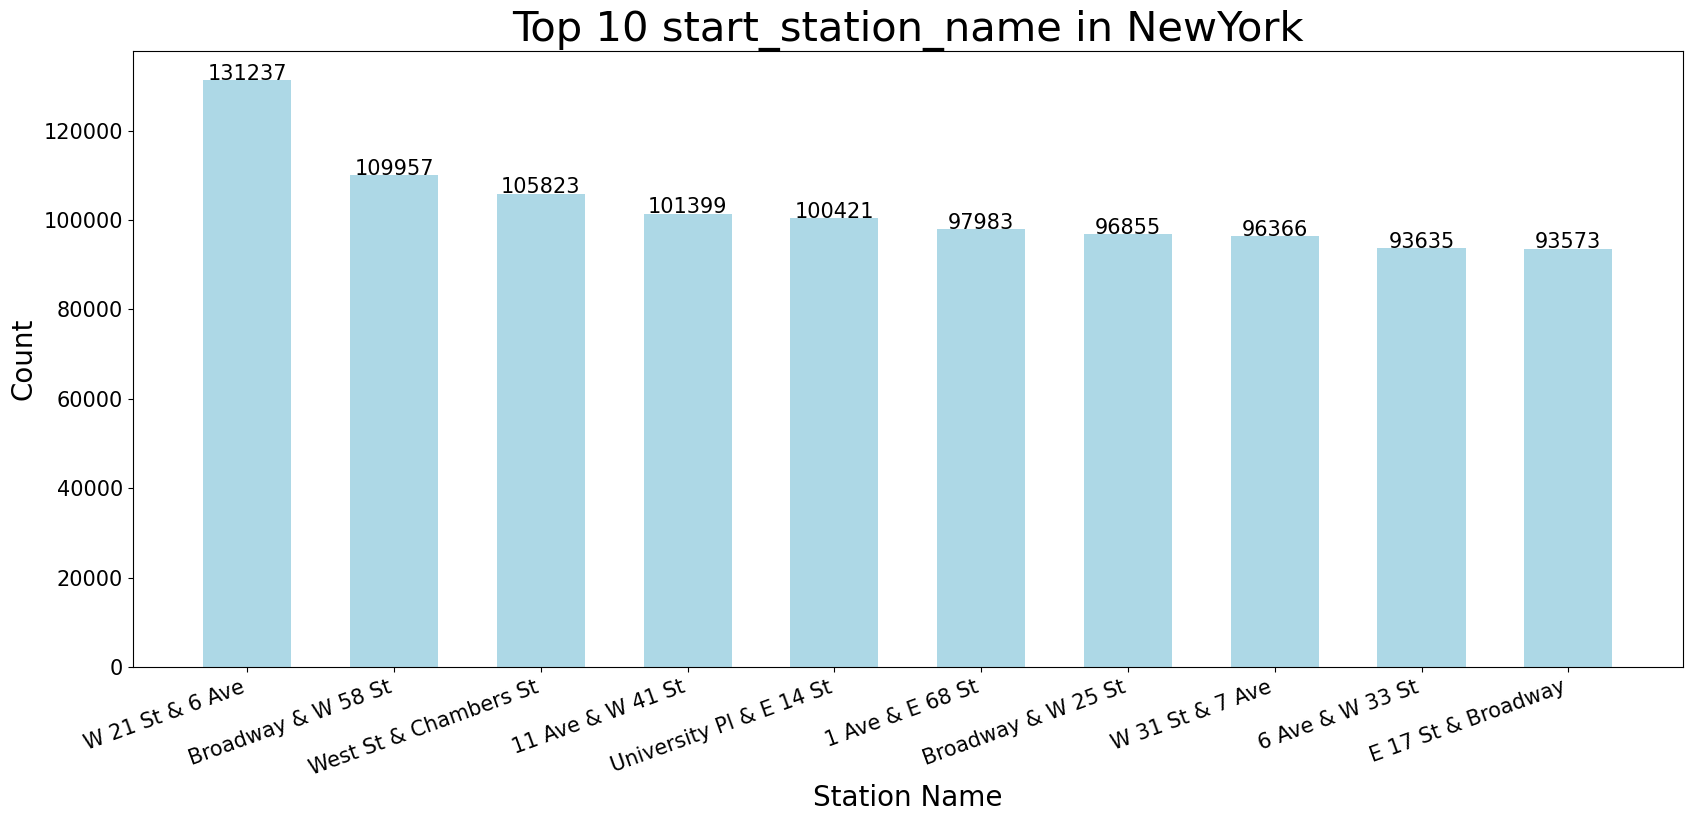

In [15]:
plot_top_stations(citybike_data, feature_name ='start_station_name')

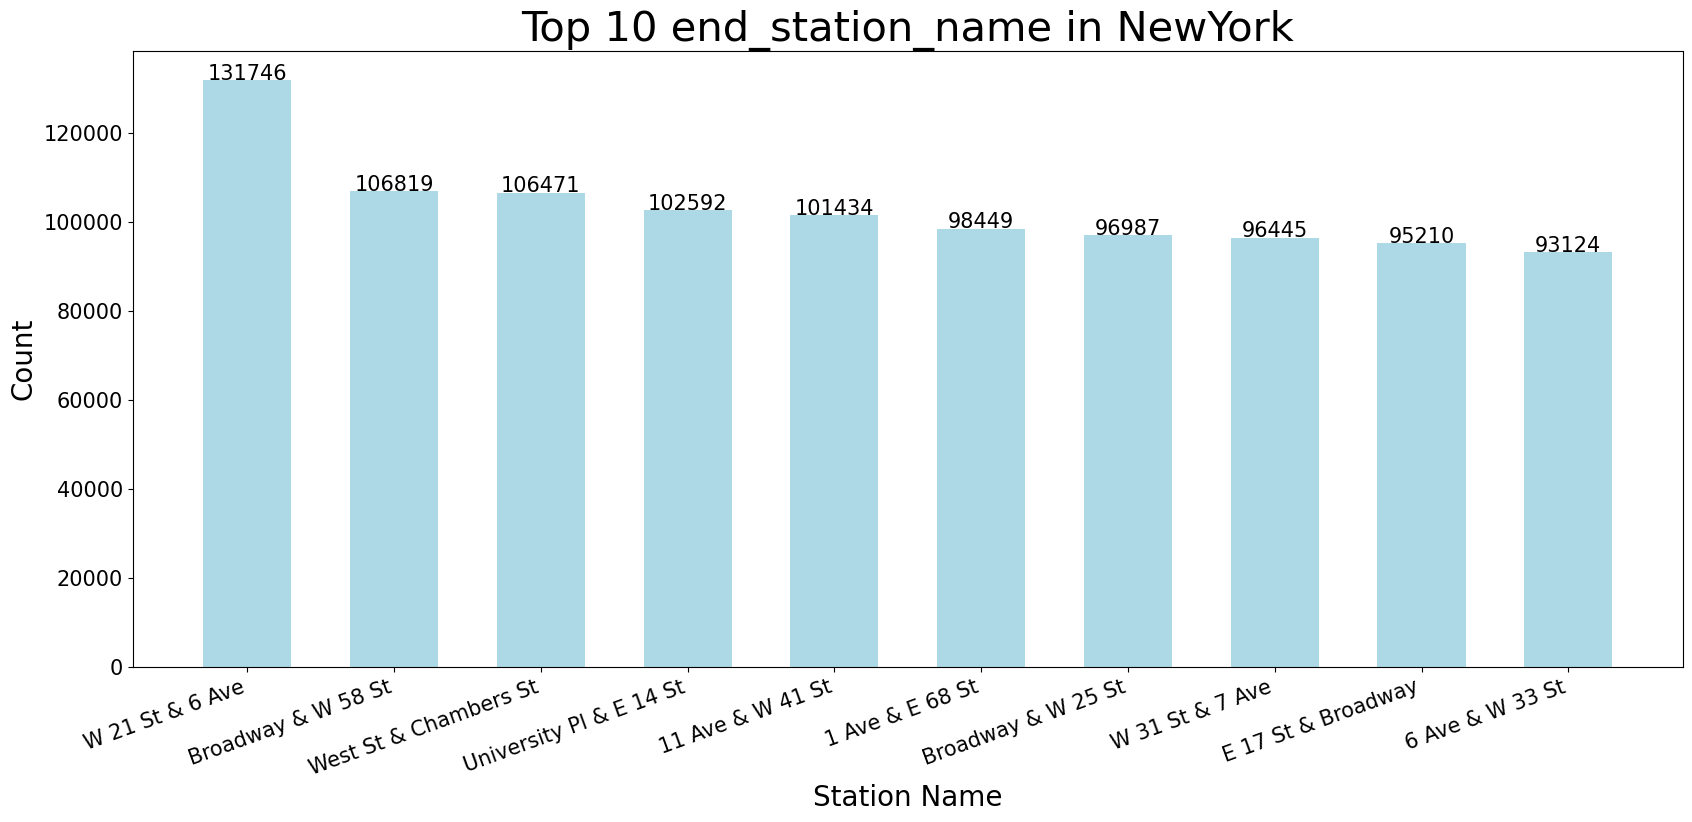

In [16]:
plot_top_stations(citybike_data, feature_name ='end_station_name')

## Time series segmentation

### Draw the plot for taxi/cityBike demand by day

In [17]:
# Separate the start time to date & hour
taxi_data = taxi_data.withColumn("date", date_format(col("tpep_pickup_datetime"), "yyyy-MM-dd"))
citybike_data = citybike_data.withColumn("date", date_format(col("started_at"), "yyyy-MM-dd"))

In [18]:
# Count by date
taxi_count_by_date = taxi_data.groupBy("date").agg(count("*").alias("taxi_count")).orderBy("date").toPandas()
citybike_count_by_date = citybike_data.groupBy("date").agg(count("*").alias("citybike_count")).orderBy("date").toPandas()

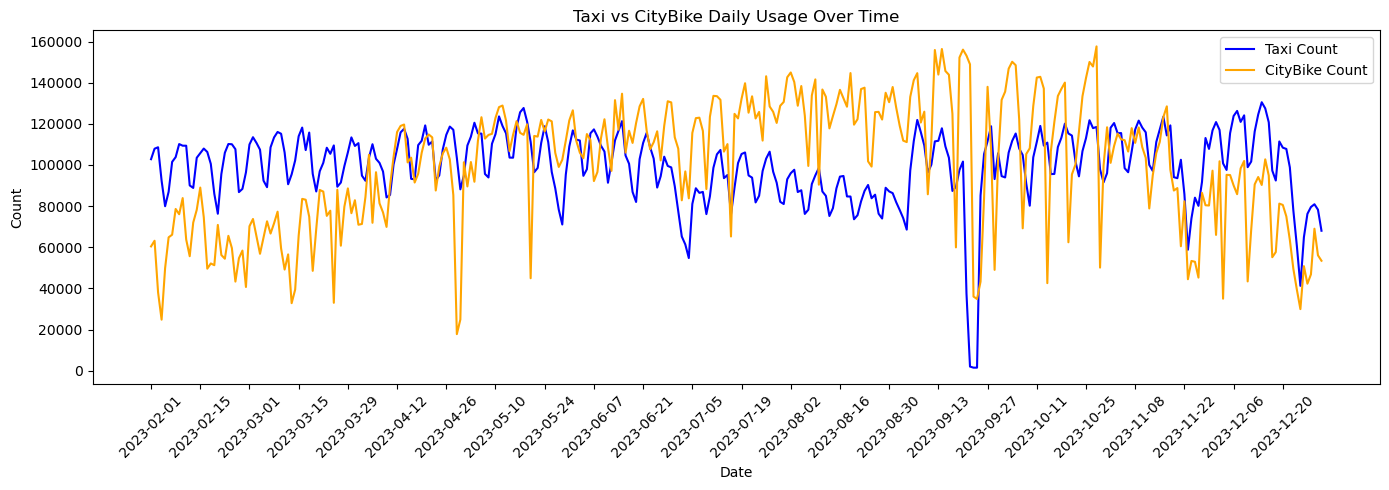

In [19]:
# Draw the time series for Taxi and CityBike data
plt.figure(figsize=(14, 5))
plt.plot(taxi_count_by_date["date"], taxi_count_by_date["taxi_count"], label="Taxi Count", color="blue")
plt.plot(citybike_count_by_date["date"], citybike_count_by_date["citybike_count"], label="CityBike Count", color="orange")
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Taxi vs CityBike Daily Usage Over Time")
plt.legend()
dates = citybike_count_by_date["date"]
plt.xticks(ticks=range(0, len(dates), 14), labels=dates[::14], rotation=45)
plt.tight_layout()
plt.show()

### Draw the plot for taxi/cityBike demand by week

In [20]:
# Extract the hour and day of the week
taxi_data = taxi_data.withColumn("hour", hour(col("tpep_pickup_datetime")))
taxi_data = taxi_data.withColumn("day_of_week", dayofweek(col("tpep_pickup_datetime")))
citybike_data = citybike_data.withColumn("hour", hour(col("started_at")))
citybike_data = citybike_data.withColumn("day_of_week", dayofweek(col("started_at")))

In [21]:
# Count by date and hour
taxi_grouped = taxi_data.groupBy("hour", "day_of_week").count().orderBy("hour", "day_of_week")
taxi_grouped_pd = taxi_grouped.toPandas()
citybike_grouped = citybike_data.groupBy("hour", "day_of_week").count().orderBy("hour", "day_of_week")
citybike_grouped_pd = citybike_grouped.toPandas()

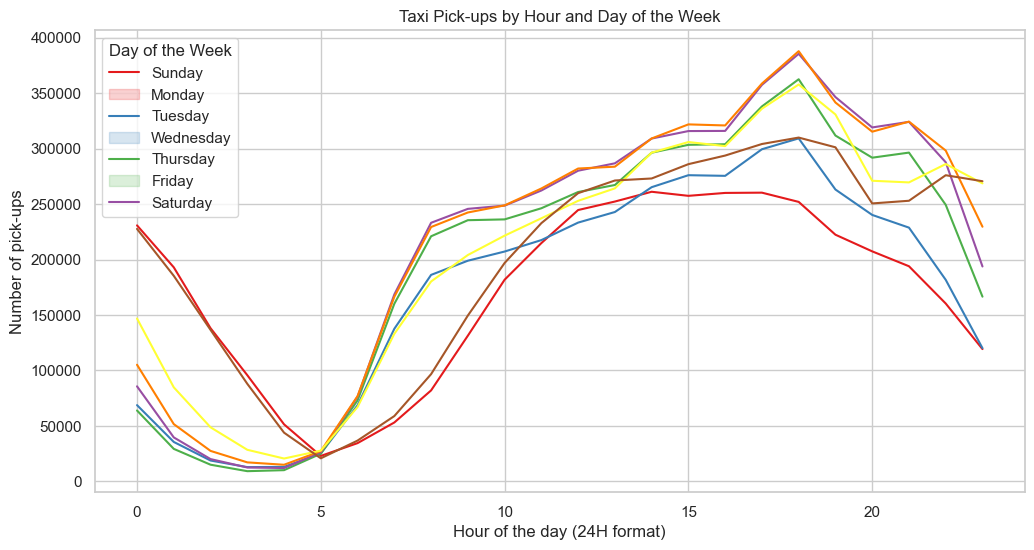

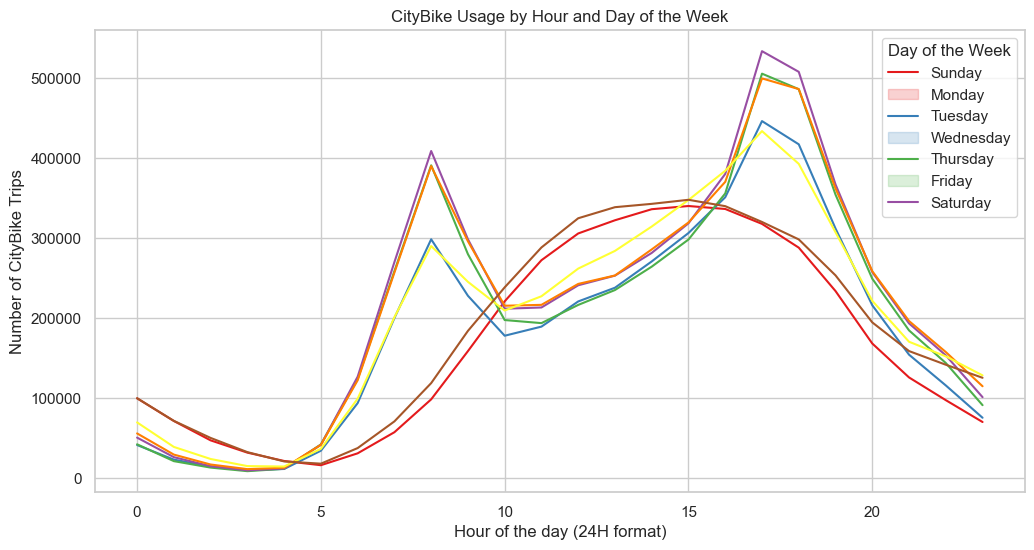

In [22]:
# Draw the plot
sns.set(style="whitegrid")

# Plot taxi usage
plt.figure(figsize=(12, 6))
sns.lineplot(x="hour", y="count", hue="day_of_week", data=taxi_grouped_pd, palette="Set1")
plt.title("Taxi Pick-ups by Hour and Day of the Week")
plt.xlabel("Hour of the day (24H format)")
plt.ylabel("Number of pick-ups")
plt.legend(title="Day of the Week", labels=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.show()

# Plot cityBike usage
plt.figure(figsize=(12, 6))
sns.lineplot(x="hour", y="count", hue="day_of_week", data=citybike_grouped_pd, palette="Set1")
plt.title("CityBike Usage by Hour and Day of the Week")
plt.xlabel("Hour of the day (24H format)")
plt.ylabel("Number of CityBike Trips")
plt.legend(title="Day of the Week", labels=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.show()


## The Distribution of categorial data

### Categorical Data of taxi_data

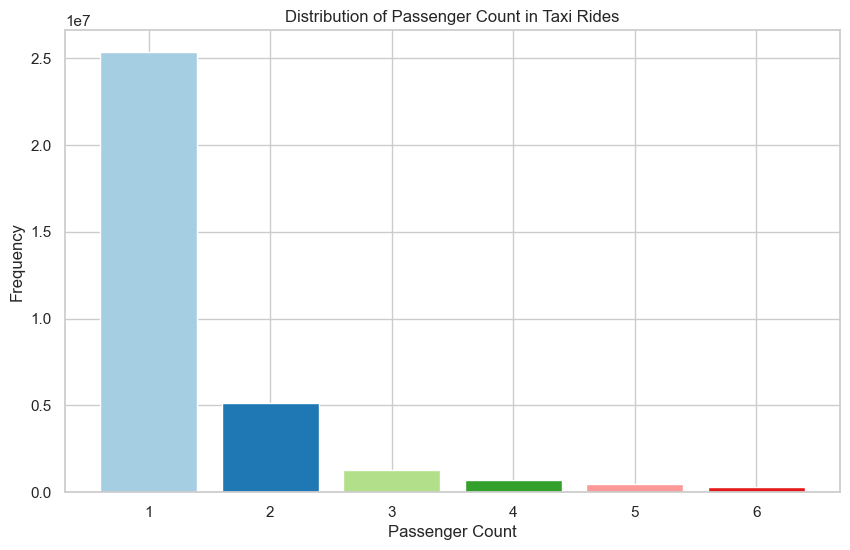

In [23]:
# Group by passenger_count and aggregate the counts
passenger_count = taxi_data.groupBy("passenger_count").agg(count("*").alias("count")).orderBy("passenger_count").toPandas()

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(passenger_count["passenger_count"], passenger_count["count"], color=plt.cm.Paired.colors)
plt.title("Distribution of Passenger Count in Taxi Rides")
plt.xlabel("Passenger Count")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.show()

### Categorical data of cityBike

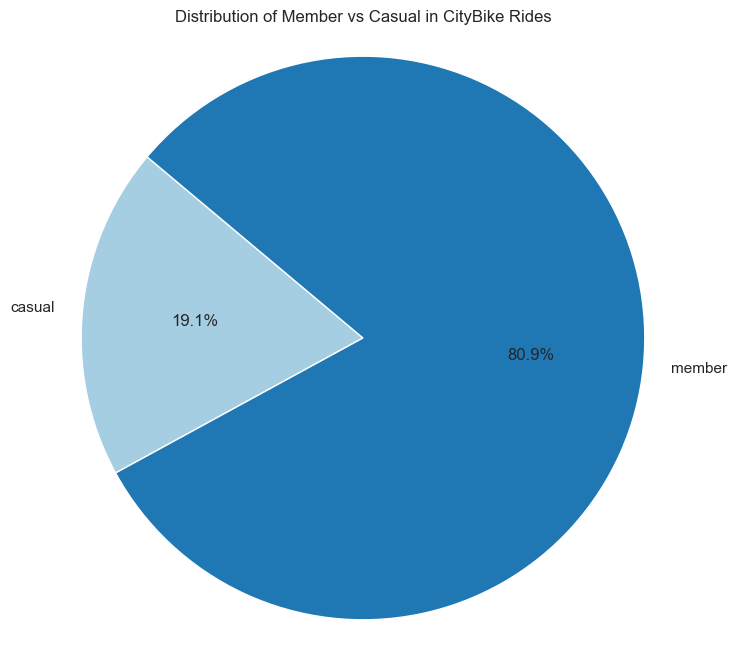

In [24]:
# Group by member_causual and aggregate the counts
member_casual_distribution = citybike_data.groupBy("member_casual").agg(count("*").alias("count")).orderBy("member_casual").toPandas()
# plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(member_casual_distribution["count"], labels=member_casual_distribution["member_casual"], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Distribution of Member vs Casual in CityBike Rides")
plt.axis('equal') 
plt.show()

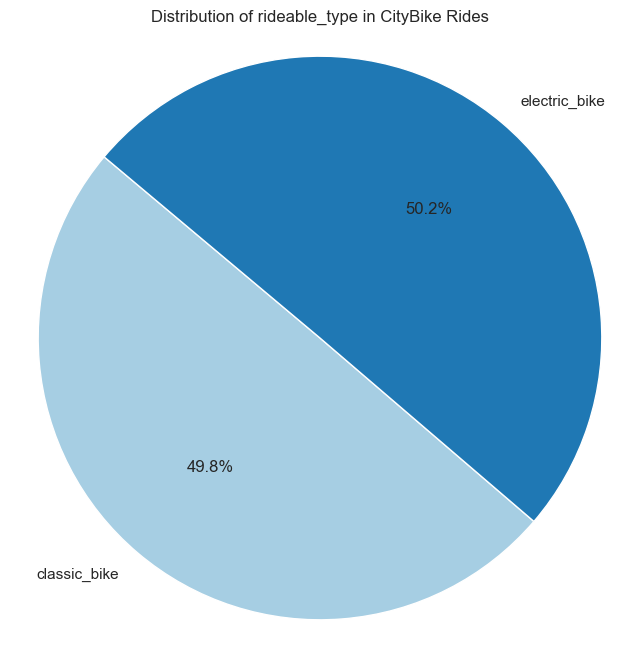

In [25]:
# Group by rideable_type and aggregate the counts
rideable_type_distribution = citybike_data.groupBy("rideable_type").agg(count("*").alias("count")).orderBy("rideable_type").toPandas()
plt.figure(figsize=(8, 8))
plt.pie(rideable_type_distribution["count"], labels=rideable_type_distribution["rideable_type"], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Distribution of rideable_type in CityBike Rides")
plt.axis('equal') 
plt.show()

### Categorical data of weather

In [26]:
# The function use to plot the distribution of categorical data
def plot_categorical_distributions_grid(df, categorical_columns):
    categorical_df = df.select(categorical_columns).toPandas()
    num_cols = 3 
    num_rows = (len(categorical_columns) + num_cols - 1) // num_cols 
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 4))
    axes = axes.flatten()
    
    for i, column in enumerate(categorical_df.columns):
        order = df.groupBy(column).agg(count("*").alias("count")).orderBy("count", ascending=False).select(column).rdd.flatMap(lambda x: x).collect()
        sns.countplot(x=column, data=categorical_df.dropna(), order=order, ax=axes[i], width= 1) 
        axes[i].set_title(f"Distribution of {column}")
        axes[i].set_xlabel(column.capitalize())
        axes[i].set_ylabel('Frequency')
        axes[i].tick_params(axis='x', rotation=50)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout() 
    plt.show()

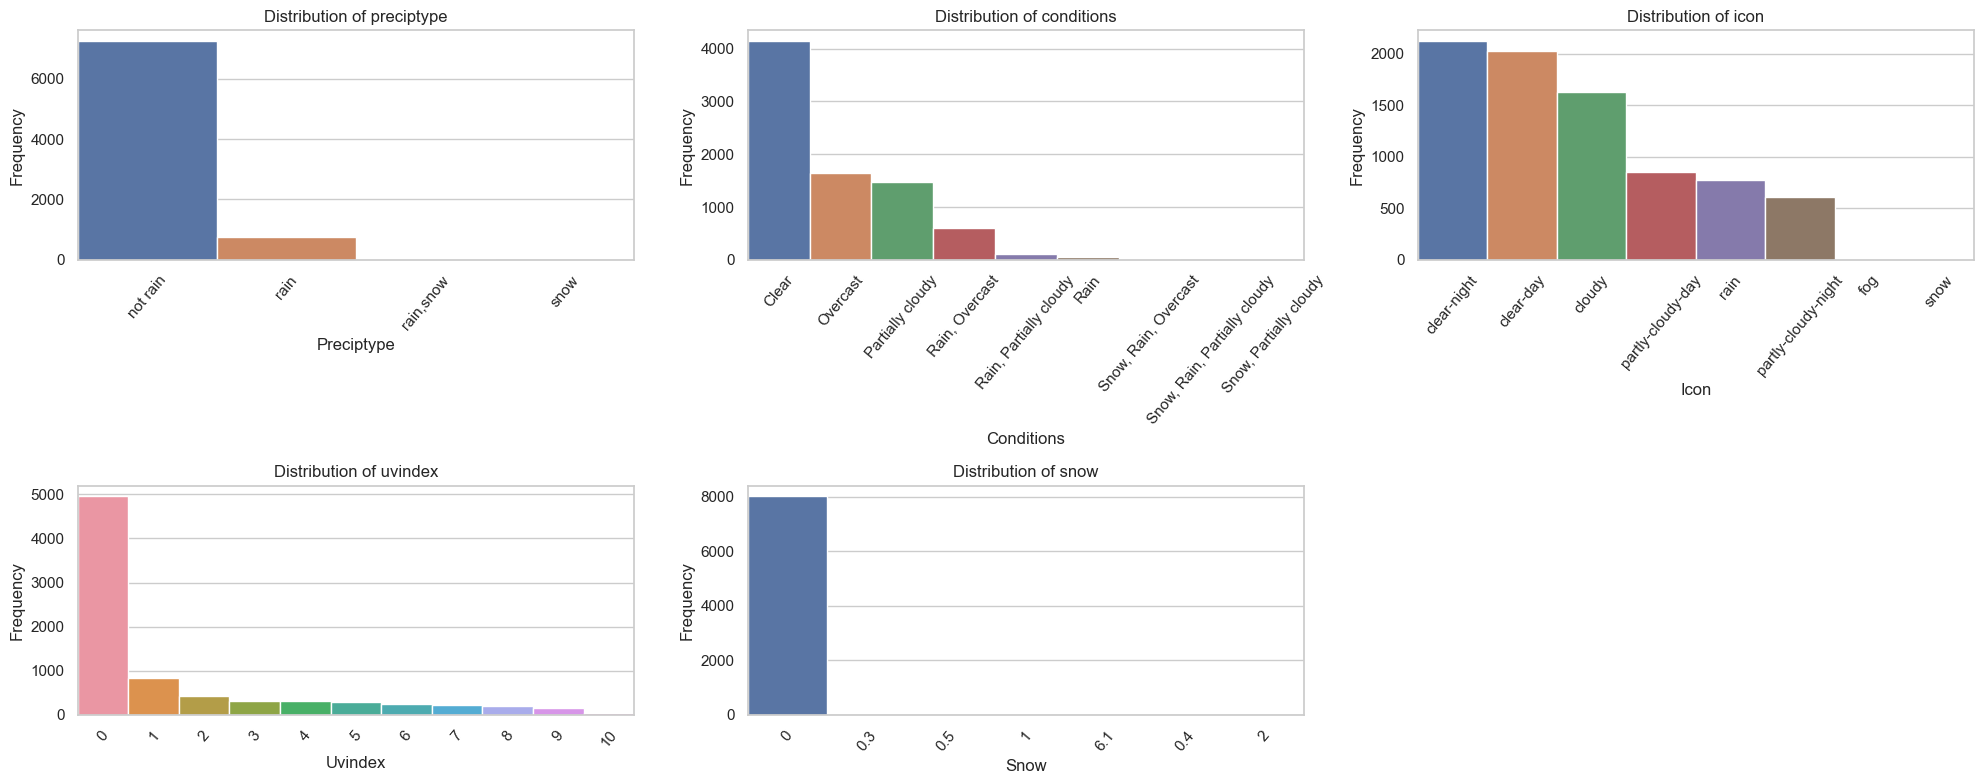

In [27]:
plot_categorical_distributions_grid(weather_data, ['preciptype','conditions','icon','uvindex','snow'])

## The Distribution of numerical data

In [28]:
# The function use to draw the distribution of numerical data
def plot_numerical_distributions_grid(df, numeric_columns):
    numeric_df = df.select(numeric_columns).toPandas()
    numeric_df = numeric_df.apply(pd.to_numeric, errors='coerce')
    num_cols = 5
    num_rows = -(-len(numeric_columns) // num_cols) 
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 16))
    axes = axes.flatten() 

    for i, column in enumerate(numeric_df.columns):
        sns.histplot(numeric_df[column].dropna(), kde=True, bins=30, ax=axes[i])
        axes[i].set_title(f'Distribution of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout() 
    plt.show()  


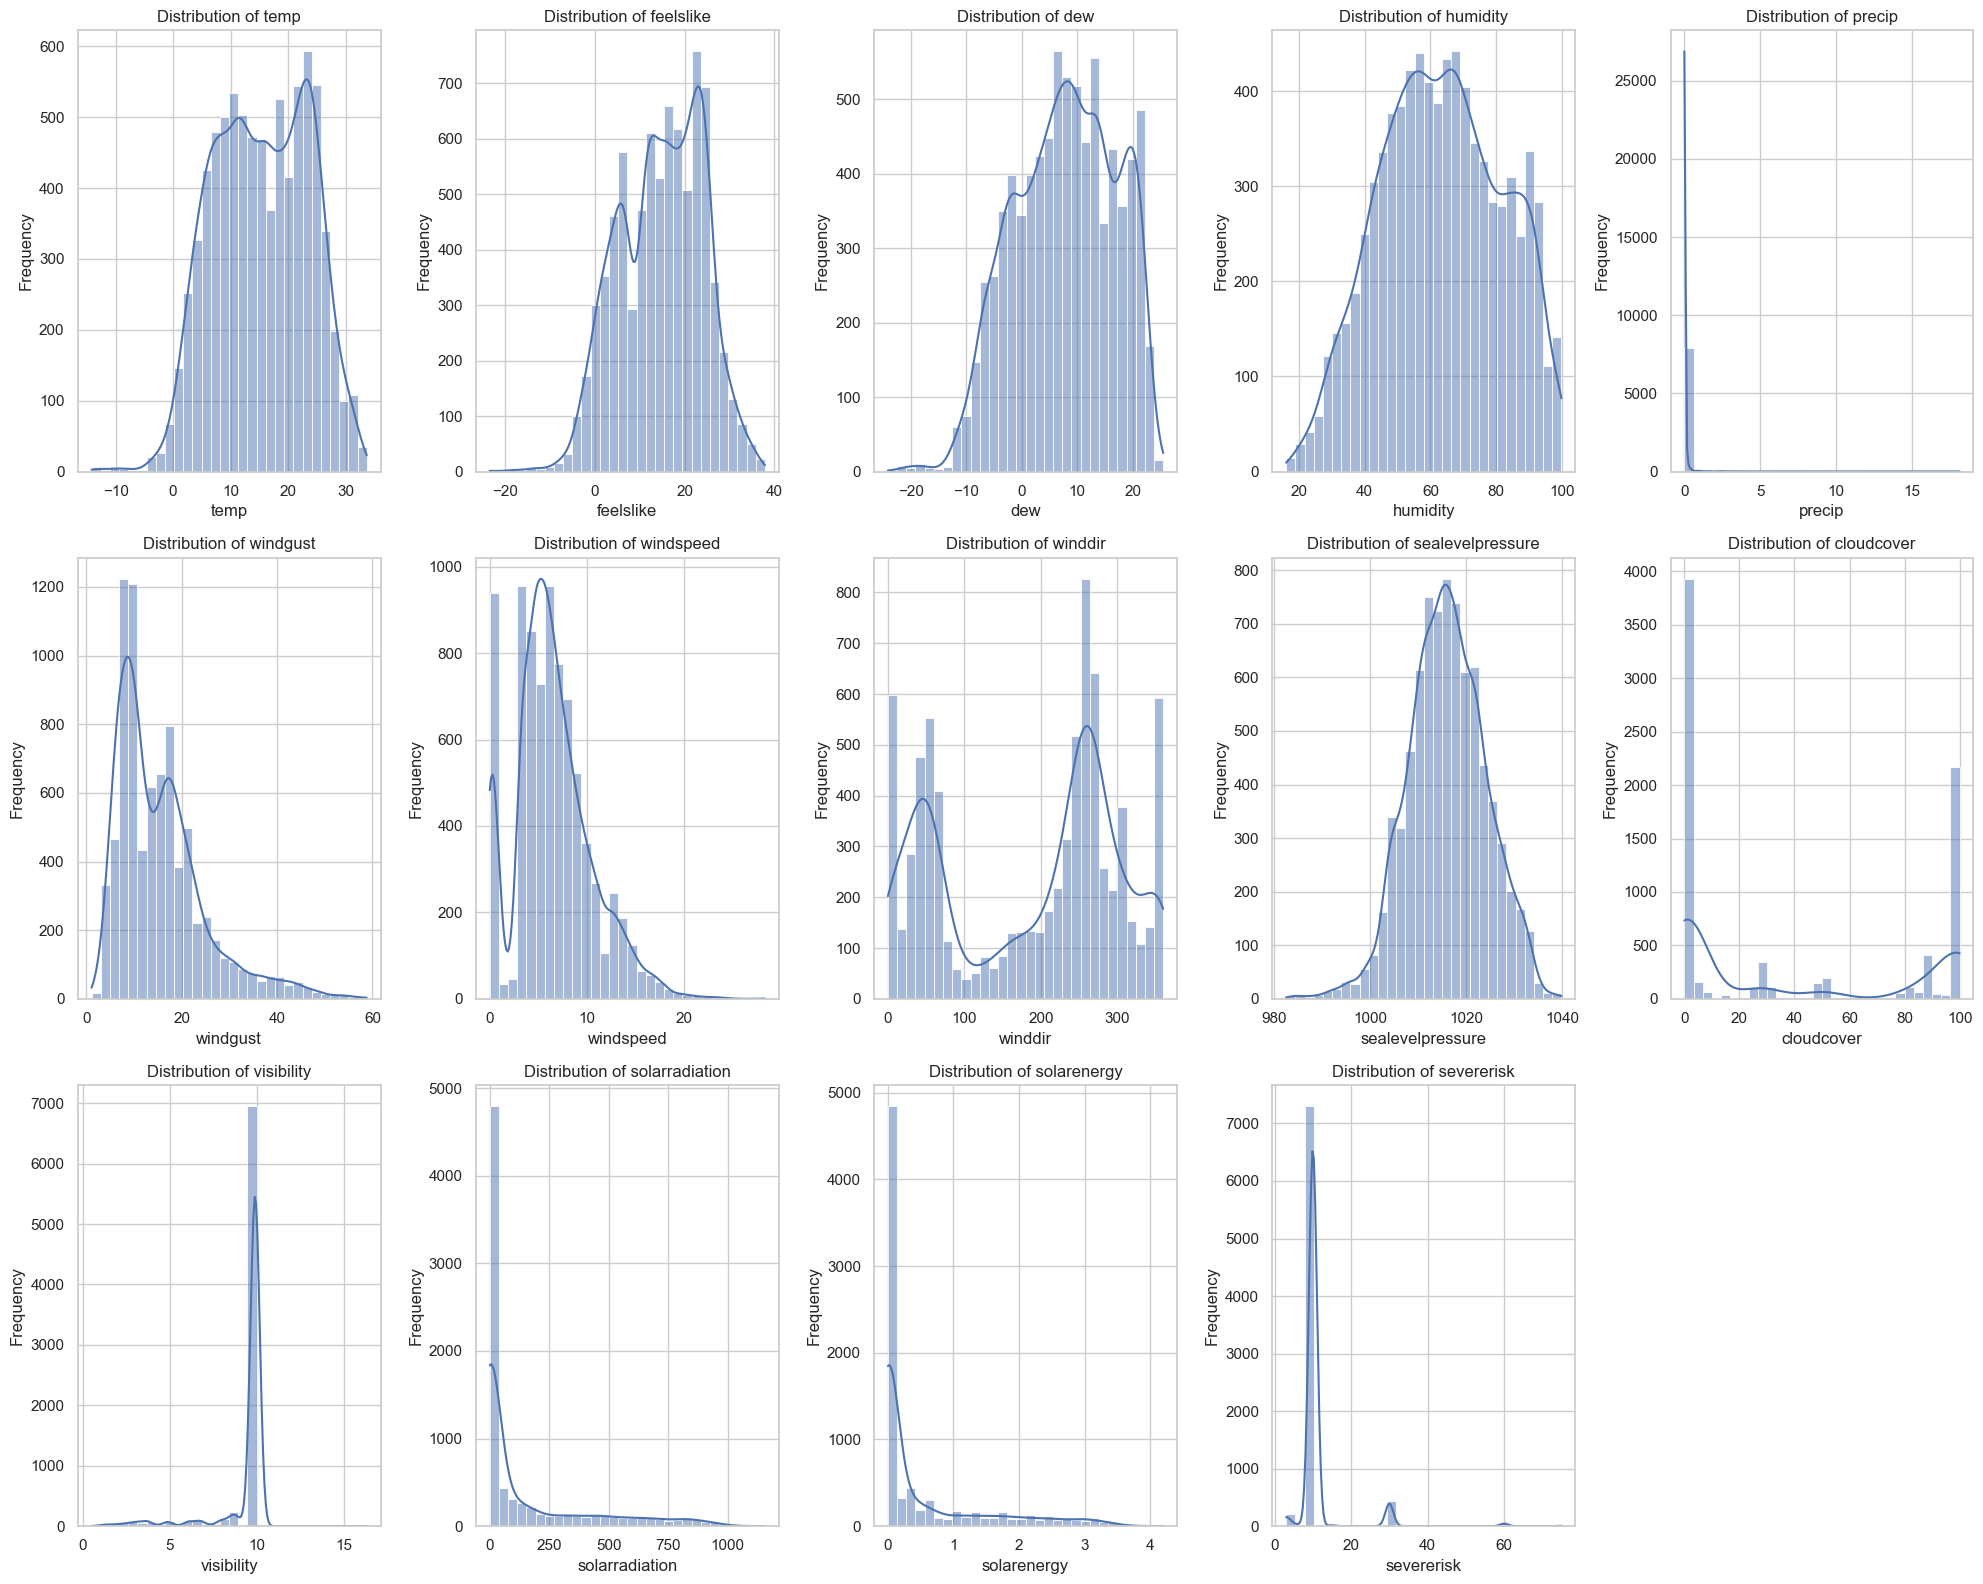

In [29]:
# The numerical Attribute need check the distribution
numeric_columns = ['temp', 'feelslike', 'dew', 'humidity', 'precip', 
            'windgust', 'windspeed', 'winddir', 
           'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 
           'solarenergy','severerisk']
plot_numerical_distributions_grid(weather_data, numeric_columns)

## Merge the weather data with taxi_data and cityBike date

In [30]:
# count taxi_data by date and hour
taxi_hourly_count = taxi_data.groupBy("date", "hour").agg(count("*").alias("taxi_count"))
citybike_hourly_count = citybike_data.groupBy("date", "hour").agg(count("*").alias("citybike_count"))
# count cityBike_data by date and hour
weather_data = weather_data.withColumn("date", date_format(col("datetime"), "yyyy-MM-dd"))
weather_data = weather_data.withColumn("hour", hour(col("datetime")))
# combine the data of weather and citybike data,taxi_data
combined_taxi_weather = taxi_hourly_count.join(weather_data, on=["date", "hour"], how="inner")
combined_citybike_weather = citybike_hourly_count.join(weather_data, on=["date", "hour"], how="inner")

In [31]:
combined_taxi_weather = combined_taxi_weather.drop('date','name','stations')

In [32]:
combined_citybike_weather = combined_citybike_weather.drop('date','name','stations')

In [33]:
combined_taxi_weather.show()

+----+----------+-------------------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+----------------+-------------------+
|hour|taxi_count|           datetime|temp|feelslike| dew|humidity|precip|precipprob|preciptype|snow|snowdepth|windgust|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|severerisk|      conditions|               icon|
+----+----------+-------------------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+----------------+-------------------+
|  11|      5523|2023-11-03 11:00:00|10.6|     10.6| 2.7|   58.15|     0|         0|  not rain|   0|        0|    18.3|      8.2|    248|            1033|       0.4|       9.9|           531|        1.9|      5|        1

In [34]:
combined_citybike_weather.show()

+----+--------------+-------------------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+----------------+-------------------+
|hour|citybike_count|           datetime|temp|feelslike| dew|humidity|precip|precipprob|preciptype|snow|snowdepth|windgust|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|severerisk|      conditions|               icon|
+----+--------------+-------------------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+----------------+-------------------+
|   6|          2153|2023-11-29 06:00:00|-1.7|       -7|-6.8|   67.89|     0|         0|  not rain|   0|        0|    18.3|     11.1|    260|          1020.4|         0|       9.9|             0|          0| 

## Add new Attribute: Day of week

In [35]:
combined_citybike_weather = combined_citybike_weather.withColumn("day_of_week", date_format(combined_citybike_weather["datetime"], 'E')).drop('datetime')

In [36]:
combined_citybike_weather.show()

+----+--------------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+----------------+-------------------+-----------+
|hour|citybike_count|temp|feelslike| dew|humidity|precip|precipprob|preciptype|snow|snowdepth|windgust|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|severerisk|      conditions|               icon|day_of_week|
+----+--------------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+----------------+-------------------+-----------+
|   6|          2153|-1.7|       -7|-6.8|   67.89|     0|         0|  not rain|   0|        0|    18.3|     11.1|    260|          1020.4|         0|       9.9|             0|          0|      0|        10|           Clear|        c

In [37]:
combined_taxi_weather = combined_taxi_weather.withColumn("day_of_week", date_format(combined_taxi_weather["datetime"], 'E')).drop('datetime')

In [38]:
combined_taxi_weather.show()

+----+----------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+----------------+-------------------+-----------+
|hour|taxi_count|temp|feelslike| dew|humidity|precip|precipprob|preciptype|snow|snowdepth|windgust|windspeed|winddir|sealevelpressure|cloudcover|visibility|solarradiation|solarenergy|uvindex|severerisk|      conditions|               icon|day_of_week|
+----+----------+----+---------+----+--------+------+----------+----------+----+---------+--------+---------+-------+----------------+----------+----------+--------------+-----------+-------+----------+----------------+-------------------+-----------+
|  11|      5523|10.6|     10.6| 2.7|   58.15|     0|         0|  not rain|   0|        0|    18.3|      8.2|    248|            1033|       0.4|       9.9|           531|        1.9|      5|        10|           Clear|          clear-day|     

## Check the correlation between the categorical data and "count"

In [39]:
# The function use to check the correlation by chi-square tesy
def chi_square_test(df, col1, col2):
    contingency_table = df.groupby(col1, col2).agg(spark_count("*").alias("count")).toPandas()
    contingency_table_pivot = contingency_table.pivot(index=col1, columns=col2, values='count').fillna(0)
    chi2_stat, p, dof, ex = chi2_contingency(contingency_table_pivot.values)
    return chi2_stat, p

In [40]:
# check the categorical data of combined_taxi_weather
columns_to_test = ['hour','preciptype', 'conditions', 'icon', 'day_of_week','uvindex']
for col in columns_to_test:
    chi2_stat, p_value = chi_square_test(combined_taxi_weather, col, 'taxi_count')
    print(f"Chi-Square Test between {col} and 'taxi_count': chi2_stat={chi2_stat:.4f}, p-value={p_value:.4f}")

Chi-Square Test between hour and 'taxi_count': chi2_stat=120833.6174, p-value=0.0000


Chi-Square Test between preciptype and 'taxi_count': chi2_stat=17132.8677, p-value=0.0000


Chi-Square Test between conditions and 'taxi_count': chi2_stat=38919.7506, p-value=0.1571


Chi-Square Test between icon and 'taxi_count': chi2_stat=34475.6124, p-value=0.0055


Chi-Square Test between day_of_week and 'taxi_count': chi2_stat=29775.5464, p-value=0.0005


Chi-Square Test between uvindex and 'taxi_count': chi2_stat=46895.0893, p-value=1.0000


In [41]:
# check the categorical data of combined_citybike_weather
columns_to_test = ['hour','preciptype', 'conditions', 'icon', 'day_of_week', 'uvindex']
for col in columns_to_test:
    chi2_stat, p_value = chi_square_test(combined_citybike_weather, col, 'citybike_count')
    print(f"Chi-Square Test between {col} and 'citybike_count': chi2_stat={chi2_stat:.4f}, p-value={p_value:.4f}")

Chi-Square Test between hour and 'citybike_count': chi2_stat=128466.7168, p-value=0.0000


Chi-Square Test between preciptype and 'citybike_count': chi2_stat=12682.8490, p-value=1.0000


Chi-Square Test between conditions and 'citybike_count': chi2_stat=42464.7640, p-value=0.9222


Chi-Square Test between icon and 'citybike_count': chi2_stat=36301.3714, p-value=1.0000


Chi-Square Test between day_of_week and 'citybike_count': chi2_stat=32489.6281, p-value=0.0972


Chi-Square Test between uvindex and 'citybike_count': chi2_stat=62194.3027, p-value=0.0000


## Check the correlation between the numerical data and the "count"

In [42]:
# The function use to draw the heat plot
def plot_correlation_heatmap(data, numeric_columns, title='Correlation Matrix'):
    numeric_df = data.select(numeric_columns).toPandas()
    numeric_df = numeric_df.apply(pd.to_numeric, errors='coerce')
    numeric_df = numeric_df.dropna()
    if numeric_df.shape[1] < 2:
        raise ValueError("Not enough numeric columns to compute correlation matrix.")
    correlation_matrix = numeric_df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(title)
    plt.show()


In [43]:
# The colunm use to draw the heatmap for combined_taxi_wether
numeric_columns_taxi = ['temp', 'feelslike', 'dew', 'humidity', 'precip', 
            'windgust', 'windspeed', 'winddir', 
           'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 
           'solarenergy','severerisk','taxi_count']

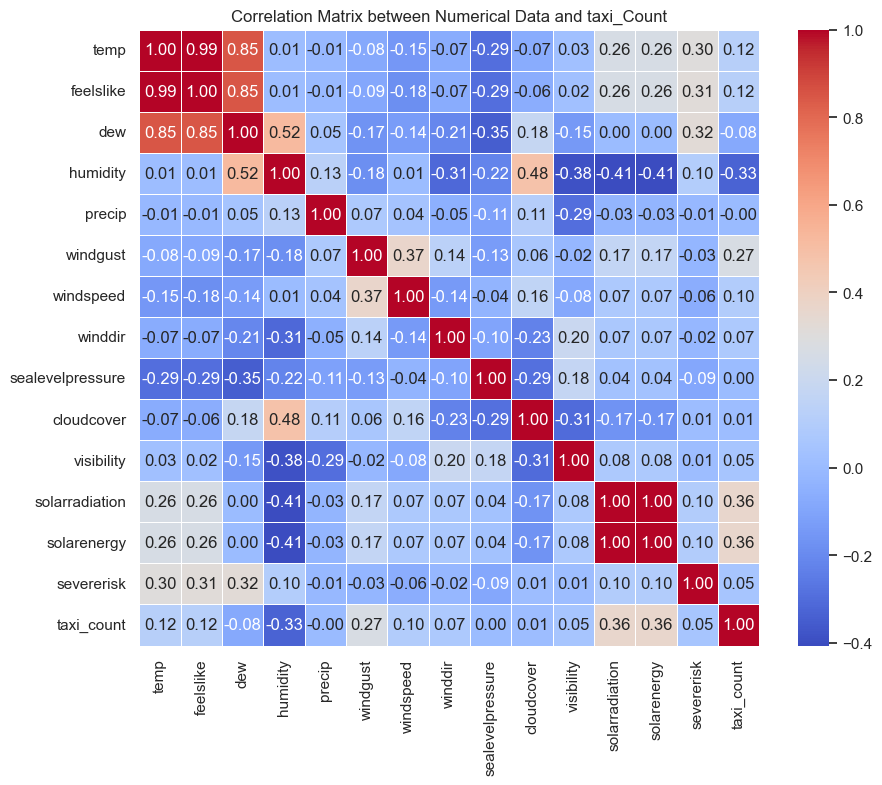

In [44]:
# draw the heatmap
plot_correlation_heatmap(combined_taxi_weather, numeric_columns_taxi, title='Correlation Matrix between Numerical Data and taxi_Count')

In [45]:
# The colunm use to draw the heatmap for combined_citybike_wether
numeric_columns_citybike = ['temp', 'feelslike', 'dew', 'humidity', 'precip', 
            'windgust', 'windspeed', 'winddir', 
           'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 
           'solarenergy','severerisk','citybike_count']

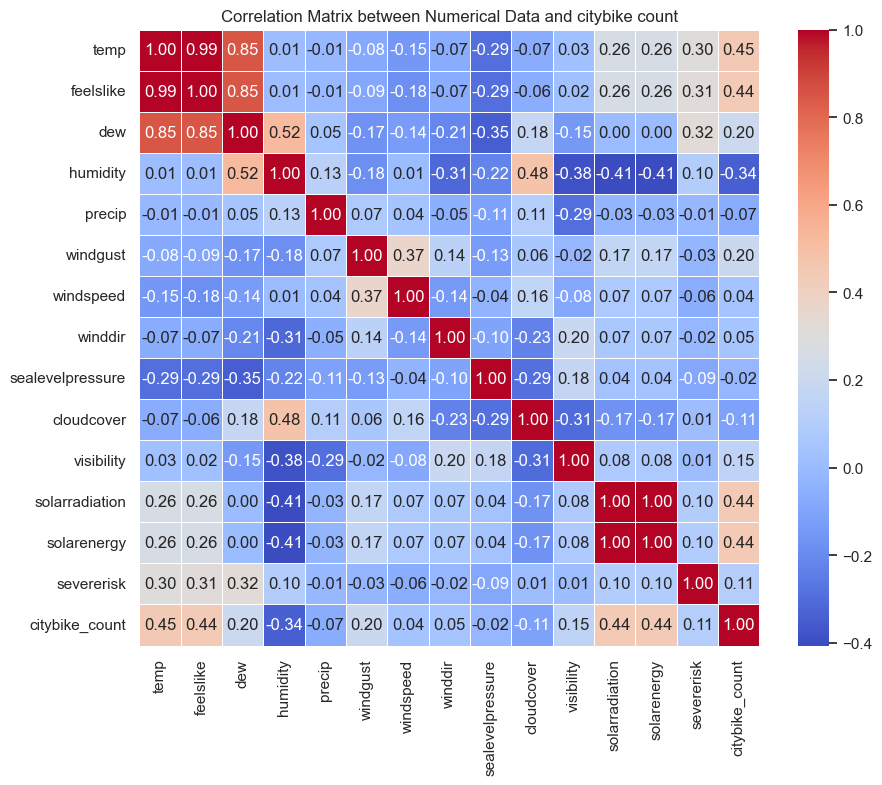

In [46]:
# draw the heatmap
plot_correlation_heatmap(combined_citybike_weather, numeric_columns_citybike, title='Correlation Matrix between Numerical Data and citybike count')

## Scaling the data

In [47]:
# The Attribute need to be scaled
numeric_columns = ['temp', 'feelslike', 'dew', 'humidity', 'precip', 
            'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'solarradiation', 
           'solarenergy','cloudcover','visibility','uvindex','severerisk']

In [48]:
from pyspark.sql.functions import col
# Make sure these Attribute is float
for col_name in numeric_columns:
    combined_citybike_weather = combined_citybike_weather.withColumn(col_name, col(col_name).cast("float"))
    combined_taxi_weather = combined_taxi_weather.withColumn(col_name, col(col_name).cast("float"))

### Log Transform

In [49]:
numeric_columns_to_transform = ['windgust', 'windspeed', 'solarenergy', 'solarradiation']

In [50]:
# take log transform
for col_name in numeric_columns_to_transform:
    combined_citybike_weather = combined_citybike_weather.withColumn(col_name, F.log1p(col(col_name)))
    combined_taxi_weather = combined_taxi_weather.withColumn(col_name, F.log1p(col(col_name)))

### Normalization

In [51]:
# Set assembler
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features")
combined_citybike_weather = assembler.transform(combined_citybike_weather)

In [52]:
combined_taxi_weather = assembler.transform(combined_taxi_weather)

In [53]:
# Standard scale the data
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(combined_citybike_weather)
combined_citybike_weather_scaled = scaler_model.transform(combined_citybike_weather)
scaler_model = scaler.fit(combined_taxi_weather)
combined_taxi_weather_scaled = scaler_model.transform(combined_taxi_weather)

24/08/22 13:50:40 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [54]:
# Convert to array format
from pyspark.ml.functions import vector_to_array
combined_citybike_weather_scaled = combined_citybike_weather_scaled.withColumn("scaled_features_dense", vector_to_array(col("scaled_features")))
combined_taxi_weather_scaled = combined_taxi_weather_scaled.withColumn("scaled_features_dense", vector_to_array(col("scaled_features")))

In [55]:
from pyspark.sql.functions import col

In [56]:
# Converts an array to a separate column
for i, col_name in enumerate(numeric_columns):
    combined_citybike_weather_scaled = combined_citybike_weather_scaled.withColumn(col_name, col("scaled_features_dense").getItem(i))
    combined_taxi_weather_scaled = combined_taxi_weather_scaled.withColumn(col_name, col("scaled_features_dense").getItem(i))

In [57]:
combined_citybike_weather_scaled = combined_citybike_weather_scaled.drop("features", "scaled_features", "scaled_features_dense")
combined_taxi_weather_scaled = combined_taxi_weather_scaled.drop("features", "scaled_features", "scaled_features_dense")

## Drop the feature that we don’t need 

In [60]:
# Attributes that are still retained
retained_attribute_taxi = ['hour','temp','humidity','preciptype','windgust','visibility','solarenergy','icon','day_of_week','taxi_count']
retained_attribute_citybike = ['hour','temp','dew','humidity','windgust','cloudcover','visibility','solarenergy','uvindex','severerisk','citybike_count']

In [61]:
combined_taxi_weather_filtered = combined_taxi_weather_scaled.select(*retained_attribute_taxi)
combined_citybike_weather_filtered = combined_citybike_weather_scaled.select(*retained_attribute_citybike)

In [62]:
combined_taxi_weather_filtered.show()

+----+--------------------+--------------------+----------+-------------------+--------------------+--------------------+-------------------+-----------+----------+
|hour|                temp|            humidity|preciptype|           windgust|          visibility|         solarenergy|               icon|day_of_week|taxi_count|
+----+--------------------+--------------------+----------+-------------------+--------------------+--------------------+-------------------+-----------+----------+
|  11| -0.5896870737724257|-0.27824657171602496|  not rain| 0.5584503060838967|  0.3330290163749476|  1.6650191425305423|          clear-day|        Fri|      5523|
|   6| -2.1042952766705487|  0.2512560090587267|  not rain| 0.5584503060838967|  0.3330290163749476| -0.6844743385380112|        clear-night|        Wed|      1586|
|   5|  -0.404978762790395|  0.3208415127216528|  not rain| 0.6722841472663952|  0.3330290163749476| -0.6844743385380112|partly-cloudy-night|        Sun|       545|
|  23|  0.

In [63]:
combined_citybike_weather_filtered.show()

+----+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+------------------+--------------+
|hour|                temp|                 dew|            humidity|           windgust|         cloudcover|         visibility|         solarenergy|             uvindex|        severerisk|citybike_count|
+----+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+------------------+--------------+
|   6| -2.1042952766705585| -1.6353515748880314|  0.2512560090587033| 0.5584503060839103|-0.8982892402394185| 0.3330290163749645| -0.6844743385380124| -0.5939413742546337|-0.201801348869187|          2153|
|  11| -0.5896870737724342| -0.5726921086707277| -0.2782465717160488| 0.5584503060839103|-0.8892822712333712| 0.3330290163749645|  1.6650191425305345|  1.4073339750623697|-0.20

In [64]:
print(combined_citybike_weather_filtered.count())
print(len(combined_citybike_weather_filtered.columns))

8016
11


In [65]:
print(combined_taxi_weather_filtered.count())
print(len(combined_taxi_weather_filtered.columns))

8016
10


## Save data

In [66]:
combined_taxi_weather_filtered.write.parquet("../data/after_EDA_data_Engineering/taxi")
combined_citybike_weather_filtered.write.parquet("../data/after_EDA_data_Engineering/citybike")